In [ ]:
# Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python

In [20]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [174]:
#      Constants and general model setup
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
p_ice = 917
cp_w = 4180            # specific heat capacity [J/(kg*K)]
cp_ice = 2100
k_w = 0.56*toyr        # thermal conductivity [(J/yr)/(m K)]
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

p_w = 1000
cp_w = 4180
k_w = 0.56 * toyr

#Julie paper

#p_ice = 917
#cp_ice = 185 + 7.037*T
#k_ice = (0.4685 + (488.12/T)) * toyr
#L=333.6*1000  

#clathrate hydrates
p_hyd = 1000
cp_hyd = 494 + (6.1*150)
k_hyd = 0.64 * toyr

#hydrated salt
p_salt = 2200
cp_salt = 920
k_salt = 0.6 * toyr

#silicate rock
p_rock = 2430
cp_rock = 2000
k_rock = 0.56 * toyr

p_boulder = (0.56*p_hyd)+(0.25*p_rock)+(0.19*p_salt)
cp_boulder = (0.56*cp_hyd)+(0.25*cp_rock)+(0.19*cp_salt)
k_boulder = (0.56*k_hyd)+(0.25*k_rock)+(0.19*k_salt)


            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=0                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.5, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##
nIce = [0, 0.2, 0.4] # Lee et al. 2005


                    ### Material 1 - Lobate
#start with 40% ice, 25% hydrates, 20% rock, 15% salts
nL = nLob[n_Sc]   
nI = nIce[n_Sc]
p_soilL = 1300       ## DENSITY (thermal model; 2B)             
cp_soilL = 1538.46       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with temperature dependence)    
k_soilL = 1.27*toyr   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (40% ice, 25% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]
pcp = [2e6, 14e6, 4e6] #average effective heat capacity for 150<T<245, 245<T<273, and 273<T<300 K, respectively


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
print(nocell)

301


In [175]:
 ### Temperature ###
Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(nocell):
    #if 0 <= i < 2:
    #    T_ini[i] = 150.00
    #elif 2 <= i < (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] + 0.821 #K/m
    #elif i == (nocell-1)/2:
    #    T_ini[i] = 273.15
    #elif i > (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] - 0.821
    #elif i == grid_depth-1:
    #    T_ini[i] = 150.00
    #else:
    #    T_ini_1[i] = 300.00
    T_ini[i] = 273.15

#T_ini = [round(item, 3) for item in T_ini_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
print(T_ini)

[273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.1

In [176]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file
TCurve_data = pd.read_csv('cerestempcurve.txt', header=None)

T_ann10 = TCurve_data[1] #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step

print(T_ann10q[-1])

150.0


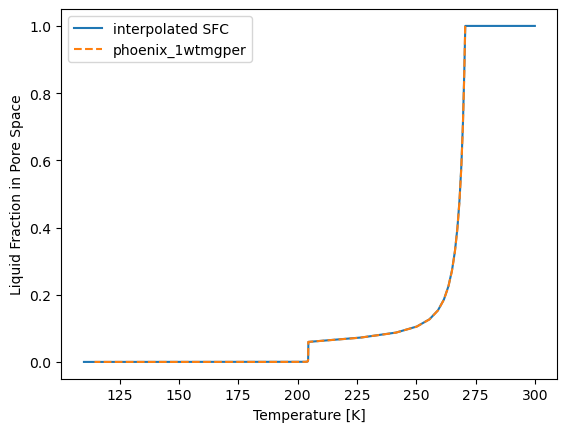

In [177]:
# reading in SFC, creating interpolated pore water fractions from input temp array and SFC

phoenix_1wtmgper = pd.read_csv('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/SFCs/phoenix_1wtmgper.txt', header=None)
fw4 = phoenix_1wtmgper[1] #liquid fraction in the pore space, Sl = 1- Si, dep variable
temp4 = -1*phoenix_1wtmgper[0] #degrees celsius, indep variable
temp4 = temp4 + 273.15 #converted temperatures to Kelvin

interp_temps = np.arange(110, 300, 0.001)
interp_fw = interp1d(temp4, fw4, kind='linear', fill_value='extrapolate')
SFC_fw = interp_fw(interp_temps)

for i in range(len(SFC_fw)): #manually set fw at 1 for all cells above freezing
    if SFC_fw[i] >= 1:
        SFC_fw[i] = 1

#interp_temps = [round(item, 3) for item in interp_temps_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
#SFC_fw = [round(item, 3) for item in SFC_fw_1]

plt.plot(interp_temps, SFC_fw, label='interpolated SFC')
plt.plot(temp4, fw4, label='phoenix_1wtmgper', linestyle='dashed')
plt.xlabel('Temperature [K]')
plt.ylabel('Liquid Fraction in Pore Space')
#plt.ylim(-0.1,1.1)
#plt.xlim(200,205)
plt.legend()

In [178]:
dfw_SFC = np.zeros(len(SFC_fw))

for i in range(len(SFC_fw)):
    if i != len(SFC_fw)-1:
        dfw_SFC[i] = (SFC_fw[i+1]-SFC_fw[i])/(interp_temps[i+1]-interp_temps[i])
    else: 
        dfw_SFC[i] = 0

#dfw_SFC = [round(item, 5) for item in dfw_SFC]
#print(dfw_SFC)

Text(0, 0.5, 'Change in liquid fraction in pore space')

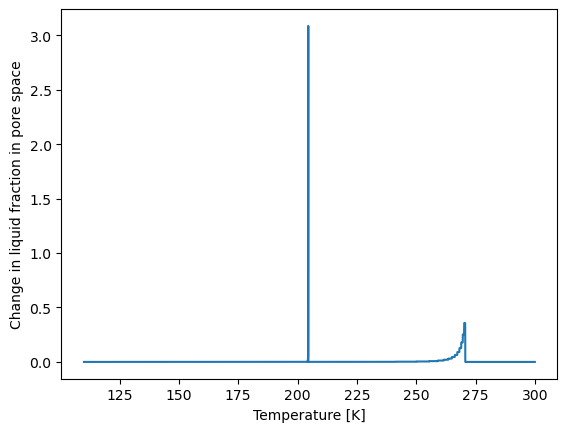

In [179]:
plt.plot(interp_temps, dfw_SFC)
plt.xlabel('Temperature [K]')
plt.ylabel('Change in liquid fraction in pore space')
#plt.xlim(204,205)

In [180]:
def get_fw(temp):
    if temp < interp_temps[0] or temp > interp_temps[-1]:
        raise ValueError("Input temperature is outside the valid range.")
    
    indices = np.where(np.isclose(interp_temps, temp, atol=1e-6))[0]
    if len(indices) == 0:
        raise ValueError("Input temperature not found in interp_temps.")
    
    index = indices[0]
    f_w_value = SFC_fw[index]
    return f_w_value

def get_dfw(temp):
    if temp < interp_temps[0] or temp > interp_temps[-1]:
        raise ValueError("Input temperature is outside the valid range.")
    
    indices = np.where(np.isclose(interp_temps, temp, atol=1e-6))[0]
    if len(indices) == 0:
        raise ValueError("Input temperature not found in interp_temps.")
    
    index = indices[0]
    df_w_value = dfw_SFC[index]
    return df_w_value

In [181]:
test = get_fw(226.13028849)
print(test)

0.07206694740952727


In [182]:
np.where(np.isclose(interp_temps, 226.13028849, atol=1e-6))[0]
print(interp_temps[116129])
print(SFC_fw[116129])

226.1290000005545
0.07206694740952727


In [183]:
### Assigning material IDs to the different model grids and creating empty vectors and matrices. ###

# 1=Lobate 2=Boulders 3=Ice
onegrid=np.ones(nocell) # 1 x 301 matrix

                # Material IDs ZONEs
Z0_1MatID=np.ones(nocell)
#Z0_1MatID[0]=3
#Z0_1MatID[1]=3
Z0_1MatID[291:]=2 #boulders (bottom 20m)

Z1_2MatID=np.ones(nocell)
#Z1_2MatID[0]=3
#Z1_2MatID[1]=3
Z1_2MatID[251:]=2 #boulders (bottom 100m)

            ### Creating one-vectors and empty matrices used in for-loop ###
n_grid=np.zeros(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
p_soil=np.zeros(nocell)
cp_soil=np.zeros(nocell)
k_soil=np.zeros(nocell)

df_w=np.zeros(nocell) ## CHANGE IN fraction of water in pore space
k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 100000

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
T_matx_0_1[:,0] = np.copy(T_ini)                                    ### add more as needed
T_matx_1_2=np.zeros((nocell,runtime))
T_matx_1_2[:,0] = np.copy(T_ini)

In [184]:
# Assign initial F_w, F_ice, f_w, and f_ice values for the model domain given the initial temperature.
# I want to match the initial temperature to whatever index it is in interp_temps, grab the value of
# that same index in SFC_fw, and set that value as the initial f_w

#for this to work, needs to be the last cell before model begins (i.e., all material properties must be set before this)

# First, initialize the fraction arrays
F_w = np.zeros(nocell)
F_ice = np.zeros(nocell)
f_w = np.zeros(nocell)
f_ice = np.zeros(nocell)
F_soil = np.zeros(nocell)

# assign values to f_w first, since this is info from SFC
for i in range(len(T_ini)): #len(T_ini) = nocell
    f_w[i] = get_fw(T_ini[i])

#using f_w values, assign initial values of other fraction arrays
for i in range(nocell):
    f_ice[i] = 1 - f_w[i]
    F_soil[i] = 1 - nL
    F_w[i] = f_w[i] * nL
    F_ice[i] = f_ice[i] * nL
    

#column-specific ice fraction arrays
f_matx_0_1=np.zeros((nocell,runtime)) #ice fraction
f_matx_0_1[:,0] = np.copy(f_ice)
f_matx_1_2=np.zeros((nocell,runtime))
f_matx_1_2[:,0] = np.copy(f_ice)

print(f_ice)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [185]:
### Numerical Model ###
# Import the LineProfiler decorator
from line_profiler import LineProfiler

# Create a LineProfiler object
profiler = LineProfiler()
@profiler
def model_run():
    start_time = time.time()

    col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    for col in col_incl:
        if col==1:            ### Defining the column in use
            runtime=100000      # Simulation runtime
            materialid=np.copy(Z0_1MatID)
        elif col==2:            ### Defining the column in use
            runtime=500      # Simulation runtime
            materialid=np.copy(Z1_2MatID)

        material_properties = {1: (nL, p_soilL, cp_soilL, k_soilL),\
                               2: (nL, p_boulder, cp_boulder, k_boulder),\
                               3: (nI, p_ice, cp_ice, k_ice)}

        for ii in range(nocell):
            if materialid[ii] in material_properties:
                n_grid[ii], p_soil[ii], cp_soil[ii], k_soil[ii] = material_properties[materialid[ii]]
            else:
                print('error')

        no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

        T_11 = np.copy(T_ann10q[:no_tstep + 1])  # Cutting temperature curve to simulation period
        T_1 = np.flip(T_11)  # New T_1 #This is just 150 K for each time step

        ### stability criterion ###
        # calculates the effective thermal diffusivity of the soil and ice material
        # if stability < 0.5, model will proceed
        k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
        C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
        a_s_ice = k_s_ice / C_s_ice
        stability = (np.max(a_s_ice) * tstep / dz**2)

        #temperature array used in numerical model
        T = np.zeros((nocell, no_tstep))
        T[:, 0] = np.copy(T_ini)

        ### heat transfer loop starts
        if col==1:
            xT_ini = np.copy(T_ini)
            k = 0 #time step count
            l = 0 #year count
            for t in range(no_tstep):
                k += 1
                for i in range(1, nocell-1): #excluding top and bottom bc they have boundary conditions
                    #xT_ini[i] = round(xT_ini[i], 5)
                    if xT_ini[i] < 100: #sanity check 
                        print(xT_ini)
                        break
                    if xT_ini[i] > 273.15:
                        f_w[i] = 1
                    elif xT_ini[i] < 204: #below this temp, SFC_fw goes to 0
                        f_w[i] = 0
                    else:
                        #print(xT_ini[i])
                        f_w[i] = get_fw(xT_ini[i])

                    f_ice[i] = 1 - f_w[i]
                    F_w[i] = f_w[i] * n_grid[i]
                    F_ice[i] = f_ice[i] * n_grid[i]

                    if xT_ini[i] > 273.15:
                        df_w[i] = 0
                    elif xT_ini[i] < 204: #below this temp, SFC_fw goes to 0
                        df_w[i] = 0
                    else:
                        #df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / 0.957725) ** 2)
                        df_w[i] = get_dfw(xT_ini[i])

                    #calculating equivalent material properties
                    k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (F_w[i] * np.sqrt(k_w)) + (F_ice[i] * np.sqrt(k_ice))) ** 2
                    C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (F_w[i] * p_w * cp_w) + (F_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                    a_eq[i] = k_eq[i] / C_eq[i]

                    if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                        T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                    else:
                        T[i, t] = xT_ini[i]

                    T[0, t] = T_1[t] #setting the top boundary to 150 K
                    T[nocell - 1, t] = T[nocell - 2, t] + (dz * T_gradient) # constant flux BC

                xT_ini = np.copy(T[:, t])    ### Value used in loop

                a_eq_0_1=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
                C_eq_0_1=np.copy(C_eq)
                f_w_0_1=np.copy(f_w)
                f_ice_0_1=np.copy(f_ice)

                 ### Creating a matrix with the temperature distribution for each year
                if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                    if l != runtime:
                        ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                        # updates column of T matrix w temps from time step
                        T_matx_0_1[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                        f_matx_0_1[:,l]=np.copy(f_w)
                        l+=1 # INCREASE TO NEXT YEAR
                        k=0
                    elif l == runtime:
                        l += 1
                        k = 0

    #    elif col==2:
    #        xT_ini = np.copy(T_ini)
    #        k = 0 #time step count
    #        l = 0 #year count
    #        for t in range(no_tstep):
    #            if stability > 0.5:
    #                break
    #            k += 1
    #            for i in range(1, nocell-1): #excluding top and bottom bc they have prescribed fractions
    #                f_w[i] = get_fw(xT_ini[i])
    #                f_ice[i] = 1 - f_w[i]

                    # df_w/dT
                    #not sure how to handle this next block of code with new freezing curve
    #                if xT_ini[i] < 271.15:
    #                    df_w[i] = 0
    #                elif xT_ini[i] > 273.15:
    #                    df_w[i] = 0
    #                else:
    #                    df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # diff of eq. A — leave this for now

    #                F_w[i] = f_w[i] * n_grid[i]
    #                F_ice[i] = f_ice[i] * n_grid[i]

                    #calculating equivalent material properties
    #                k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (f_w[i] * np.sqrt(k_w)) + (f_ice[i] * np.sqrt(k_ice))) ** 2
    #                C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (f_w[i] * p_w * cp_w) + (f_ice[i] * p_ice * (cp_ice + L * df_w[i]))
    #                a_eq[i] = k_eq[i] / C_eq[i]

    #                if (xT_ini2[i + 1] - xT_ini2[i - 1]) != 0:
    #                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
    #                else:
    #                    T[i, t] = xT_ini[i]

    #                T[0, t] = T_1[t] #setting the top boundary to 150 K
    #                T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be

    #            xT_ini = np.copy(T[:, t])      ### Value used in loop

    #            a_eq_1_2=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
    #            C_eq_1_2=np.copy(C_eq)
    #            f_w_1_2=np.copy(f_w)
    #            f_ice_1_2=np.copy(f_ice)

                 ### Creating a matrix with the temperature distribution for each year
    #            if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
    #                if l != runtime:
                        ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                        # updates column of T matrix w temps from time step
    #                    T_matx_1_2[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
    #                    f_matx_1_2[:,l]=np.copy(f_w)
    #                    l+=1 # INCREASE TO NEXT YEAR
    #                    k=0
    #                elif l == runtime:
    #                    l += 1
    #                    k = 0



    print('complete')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

In [ ]:
model_run()

In [169]:
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 294.195 s
File: /var/folders/q6/f8_x77hj45d1kngmhhrc3k9r0000gn/T/ipykernel_9292/2320507184.py
Function: model_run at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           @profiler
     8                                           def model_run():
     9         1       5000.0   5000.0      0.0      start_time = time.time()
    10                                           
    11         1          0.0      0.0      0.0      col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    12         2       2000.0   1000.0      0.0      for col in col_incl:
    13         1       1000.0   1000.0      0.0          if col==1:            ### Defining the column in use
    14         1          0.0      0.0      0.0              runtime=100      # Simulation runtime
    15   

In [170]:
T_matx_0_1.shape #should be nocell x runtime

(301, 100)

In [171]:
f_w.shape

(301,)

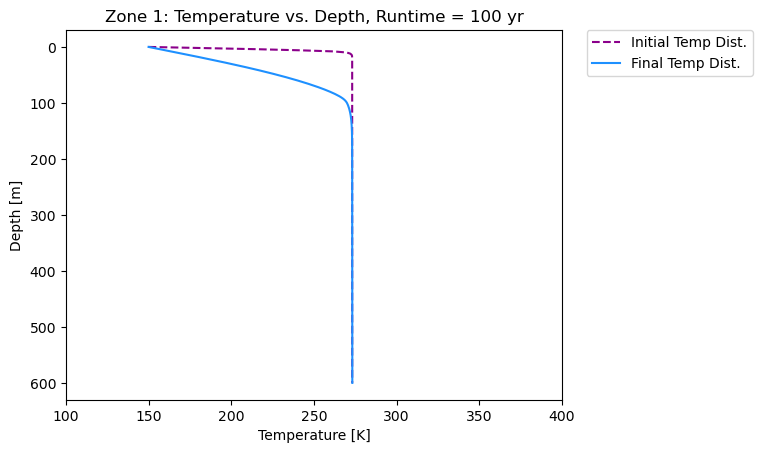

In [172]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.figure()
plt.xlim([100,400])
#plt.ylim(-.1,40)
plt.plot(T_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Temp Dist.')
plt.plot(T_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [173]:
print(T_matx_0_1[:,-1])

[150.         153.39809388 156.79339162 160.1830981  163.56442091
 166.93457302 170.29077708 173.63027148 176.95031845 180.24821396
 183.52129945 186.76697469 189.98271138 193.16606687 196.31469715
 199.42636858 202.49896772 205.5305088  208.51589117 211.45321828
 214.34074699 217.17688533 219.96018801 222.68935023 225.36320062
 227.98069393 230.53982943 233.03974093 235.47967596 237.85899324
 240.17716214 242.43376368 244.6256451  246.75252873 248.81426858
 250.81084838 252.73717321 254.59339629 256.37984722 258.08853123
 259.72037716 261.26441676 262.72337278 264.08516171 265.33640199
 266.46366823 267.45491238 268.30132413 268.99910672 269.54800919
 269.98234173 270.32583537 270.60649618 270.85988947 271.09128636
 271.30207558 271.49374381 271.66776454 271.82553069 271.96833838
 272.09739365 272.21382274 272.31867982 272.41295161 272.49756025
 272.57336542 272.6411664  272.70170429 272.75566446 272.80367914
 272.84633017 272.88415174 272.91763316 272.94722162 272.97332491
 272.99631

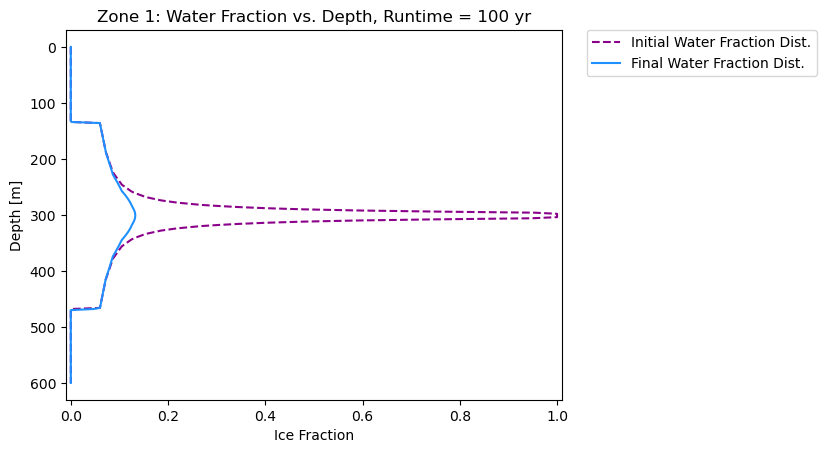

In [150]:
### Fig - Final ice fraction distrubution
#plotting curves for initial and final f_ice distributions

plt.figure()
plt.xlim([-0.01,1.01])
plt.plot(f_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Water Fraction Dist.')
plt.plot(f_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Water Fraction Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Ice Fraction')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Water Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [151]:
# when runtime is 100,000 yr, code takes ~2 hr to run

## Aggradation rate and depth of PF & FF

In [152]:
TqFF= 271.15 #K, freezing front temp
Tq_1= 272.15 #not sure what this is
TqPF= 273.15 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

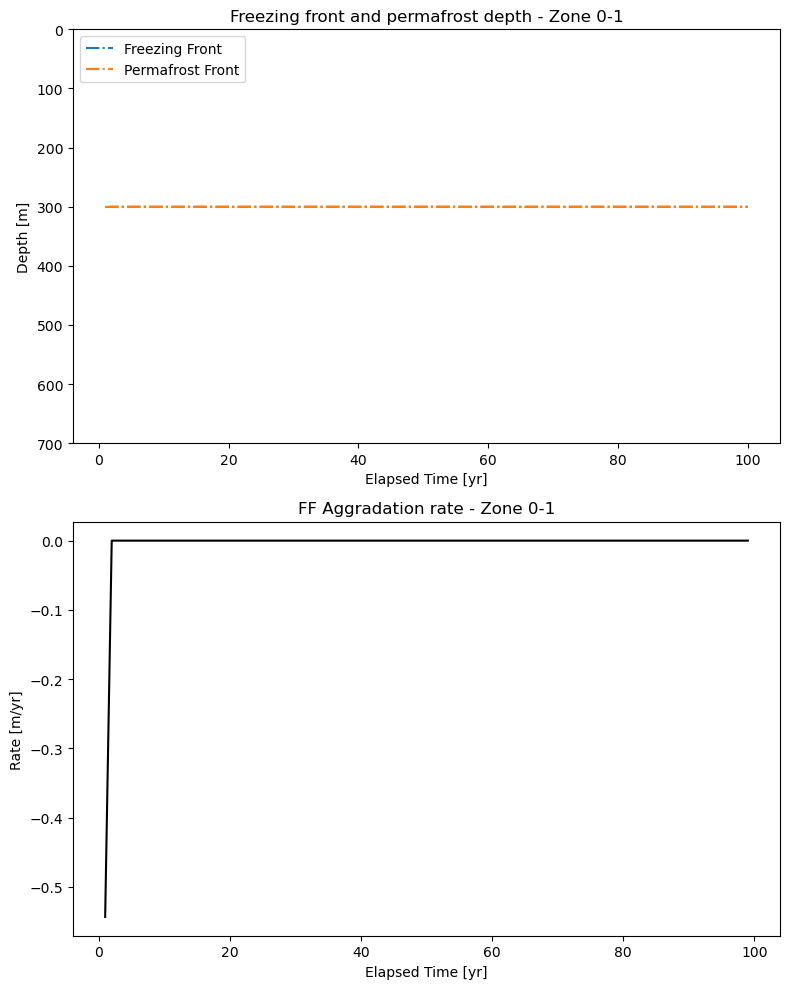

In [156]:
colcount = [1]

for col in colcount:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value
            tt[i] = t_intv * k

        colcount[0] += 1
        presentFFdepth[colcount[0]]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount[0]]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
print(zqFF)

In [ ]:
print(zqPF)

## Final PF and FF depths

In [37]:
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

/Users/alexiakubas/opt/anaconda3/envs/astromodeling/lib/python3.9/site-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/alexiakubas/opt/anaconda3/envs/astromodeling/lib/python3.9/site-packages/matplotlib/ticker.py:2126: RuntimeWarning: overflow encountered in scalar subtract
  high = edge.ge(_vmax - best_vmin)


Error in callback <function _draw_all_if_interactive at 0x13b9a3d30> (for post_execute):


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

<Figure size 640x480 with 1 Axes>

## Final Aggradation Rate and Recharge Equivalent

In [ ]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 

## Plotting Final Effective Material Properties 

In [ ]:
print(a_eq_0_1)

In [ ]:
print(C_eq_0_1)

In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective thermal diffusivity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(a_eq_0_1, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
#plt.plot(a_eq_1_2, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Thermal Diffusivity [m^2/s]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Thermal Diffusivity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective heat capacity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(C_eq_0_1/1e6, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
plt.plot(C_eq_1_2/1e6, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Heat Capacity [MJ/K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Heat Capacity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
np.shape(a_eq_0_1)